In [1]:
import numpy as np
from sigvisa import Sigvisa

from sigvisa.infer.coarse_to_fine_init import ModelSpec, EventRunSpec, TimeRangeRunSpec, do_coarse_to_fine, initialize_from, do_inference, initialize_sg
from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.treegp.gp import GPCov
from sigvisa.graph.region import Region

import cPickle as pickle

from sigvisa.utils.geog import dist_km

%matplotlib inline
import matplotlib.pylab as plt

from sigvisa.signals.common import Waveform

from sigvisa.explore.correlate_validation_events import get_training_arrivals
from sigvisa.infer.correlations.historical_signal_library import get_historical_signals
from sigvisa.source.event import get_event

In [2]:



def build_sg(stas, evid):

    runid = 17
    hz=10.0
    uatemplate_rate=4e-4
    bands=["freq_0.8_4.5"]
    phases=["Pn", "Sn", "Lg", "Pg"]
    hack_constraint = True
    raw_signals = True

    region_lon = (-126, -100)
    region_lat = (32, 49)

    runids=(runid,)

    rs = EventRunSpec(stas=stas, evids=[evid,])

    ev = get_event(evid)
    region_stime = ev.time - 150
    region_etime = ev.time + 200
    region = Region(lons=region_lon, lats=region_lat,
                    times=(region_stime, region_etime),
                    rate_bulletin="isc",
                    min_mb=2.0,
                    rate_train_start=1167609600,
                    rate_train_end=1199145600)


    ms1 = ModelSpec(template_model_type="gpparam",
                    wiggle_family="db4_2.0_3_20.0",
                    wiggle_model_type="gplocal+lld+none",
                    uatemplate_rate=uatemplate_rate,
                    max_hz=hz,
                    phases=phases,
                    bands=bands,
                    runids=runids,
                    inference_region=region,
                    dummy_fallback=False,
                    raw_signals=raw_signals,
                    skip_levels=0,
                    hack_param_constraint=hack_constraint,
                    vert_only=True)

    sg = rs.build_sg(ms1)
    return sg

In [3]:

sta="NV01"

sg = build_sg((sta,), 3375254)

proposals = get_historical_signals(sg)

phase="Lg"
evs, signals = get_training_arrivals(sta, phase, runid=17)


NV01 Lg 17 arrival 0 of 21
NV01 Lg 17 arrival 20 of 21


In [4]:
def get_proposal(ev, phase, proposals):
    for x, d in proposals:
        lon, lat, depth, _, _ = x.flatten()
        if np.abs(lon-ev.lon) > 1e-2: continue
        if np.abs(lat-ev.lat) > 1e-2: continue
        if np.abs(depth-ev.depth) > 1e-2: continue
        for (sta, chan, band, pphase), s in d.items():
            if pphase == phase:
                return s
    raise Exception("no match for %s %s" % (ev, phase))

/home/dmoore/.virtualenvs/sigvisa/local/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


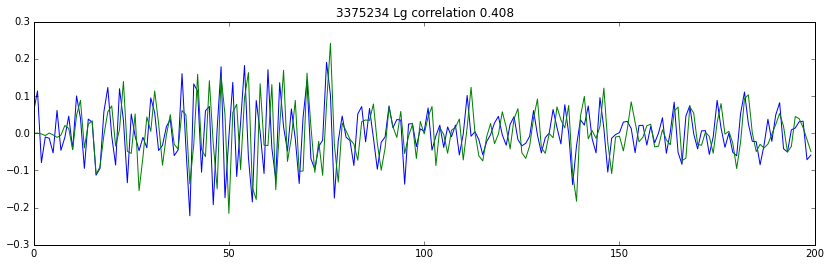

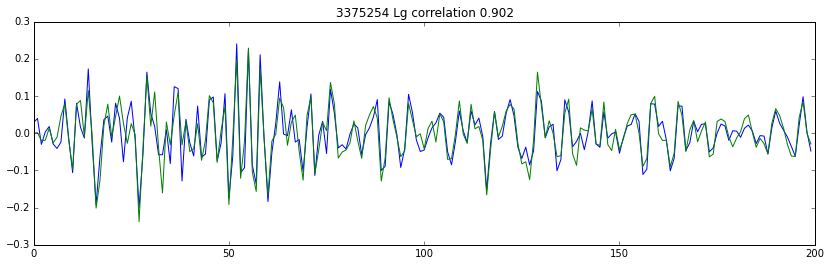

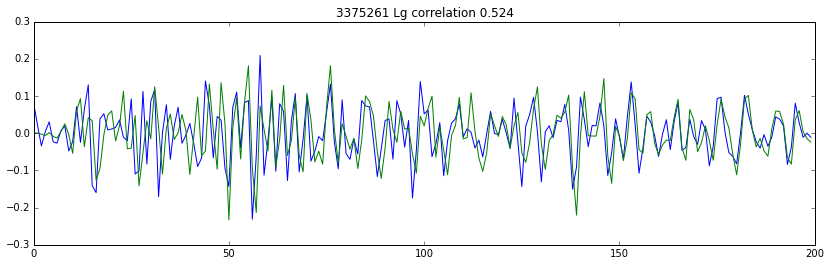

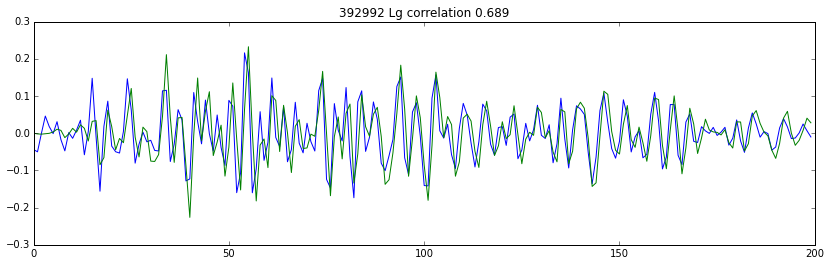

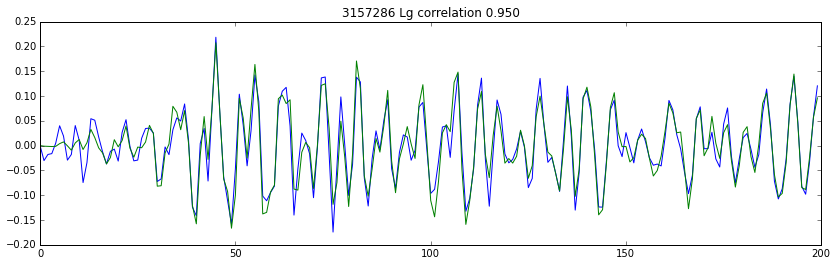

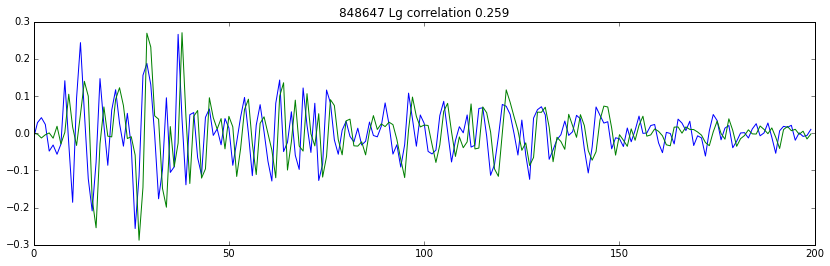

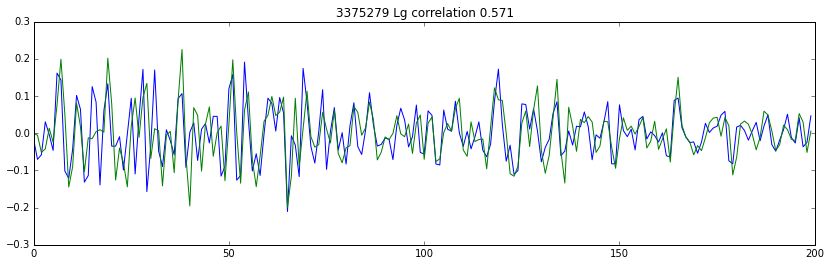

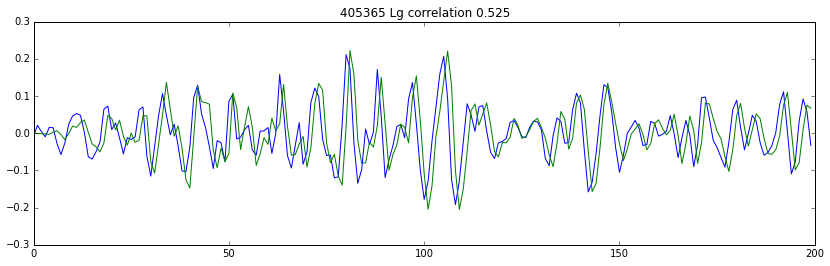

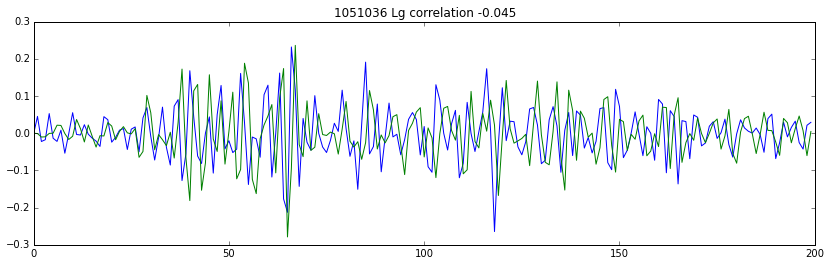

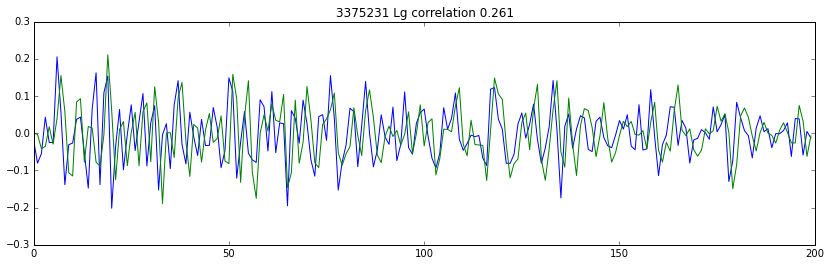

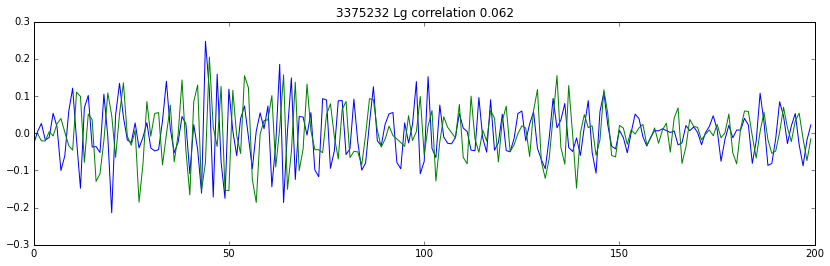

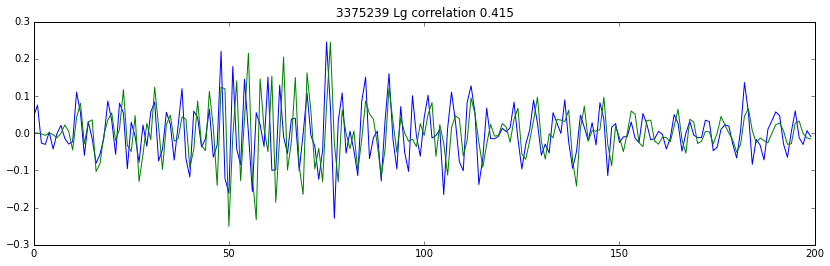

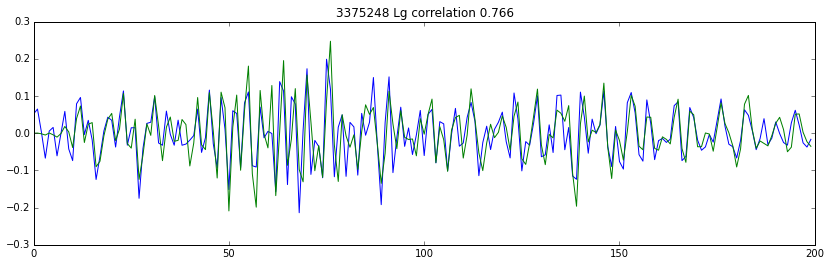

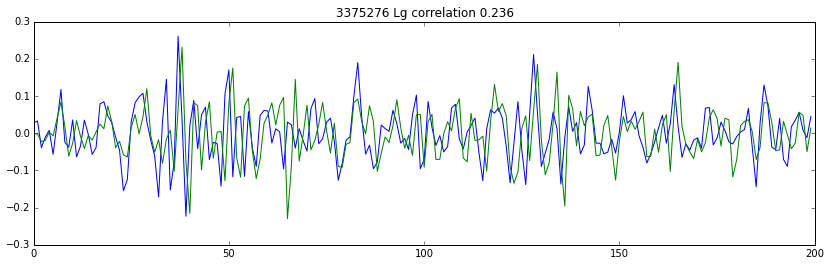

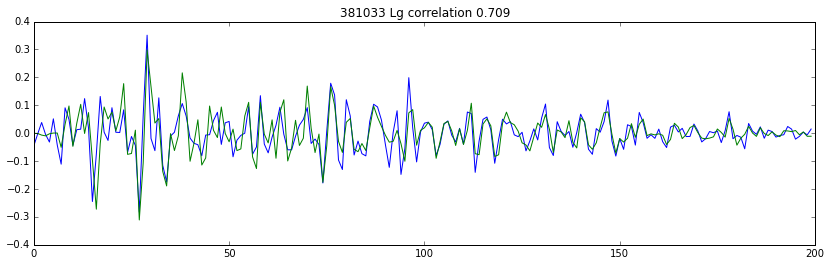

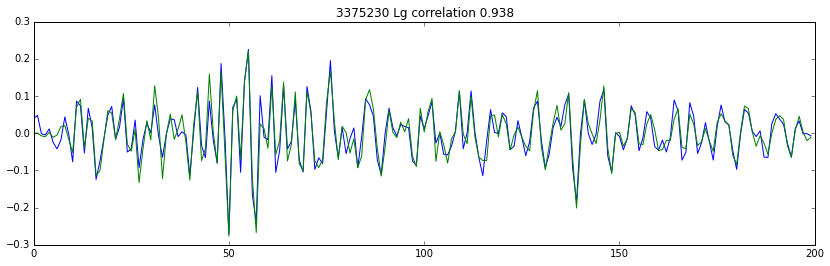

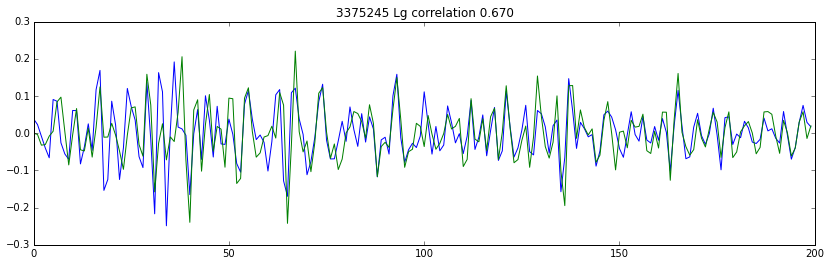

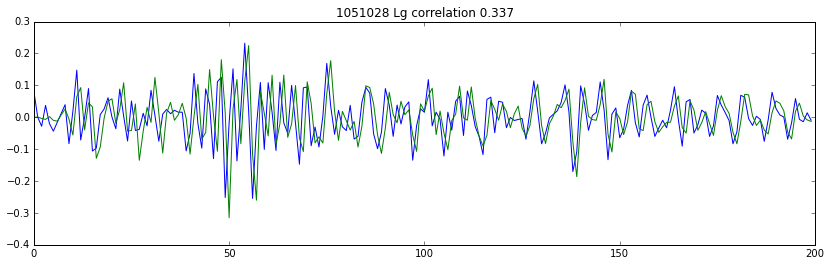

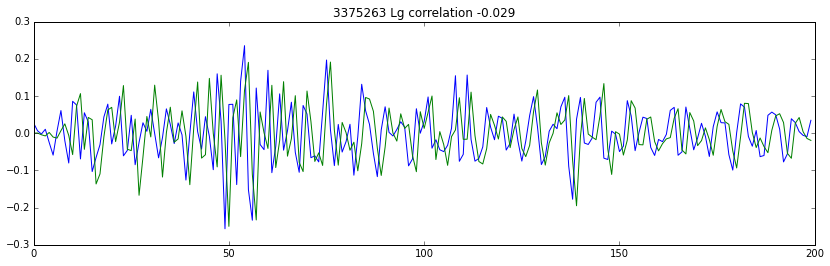

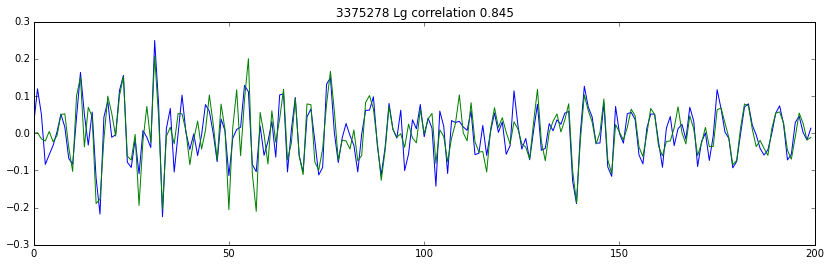

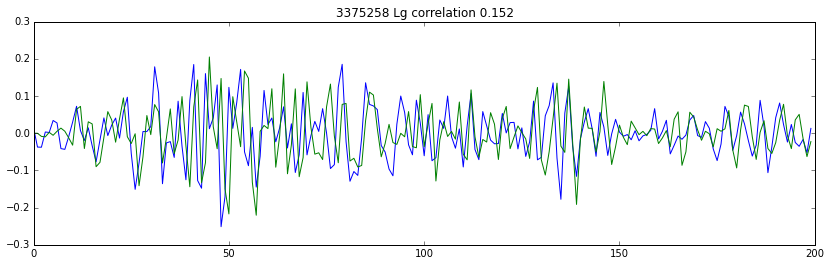

In [5]:
for (ev, s) in zip(evs, signals):
    plt.figure(figsize=(14, 4))
    norm_s = s / np.linalg.norm(s)
    plt.plot(norm_s)
    ps = get_proposal(ev, phase, proposals)
    norm_ps = ps/ np.linalg.norm(ps)
    plt.plot(norm_ps)
    plt.title("%d %s correlation %.3f" % (ev.evid, phase, np.dot(norm_s, norm_ps)))

/home/dmoore/python/sigvisa/infer/correlations/weighted_event_posterior.py:87: RuntimeWarning: divide by zero encountered in log
  origin_ll = np.log(rr) + llmax


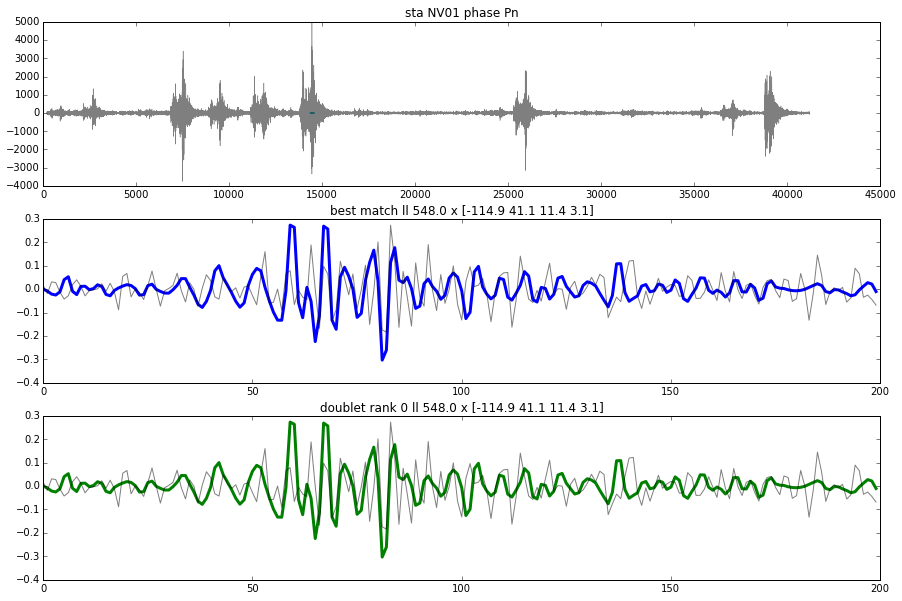

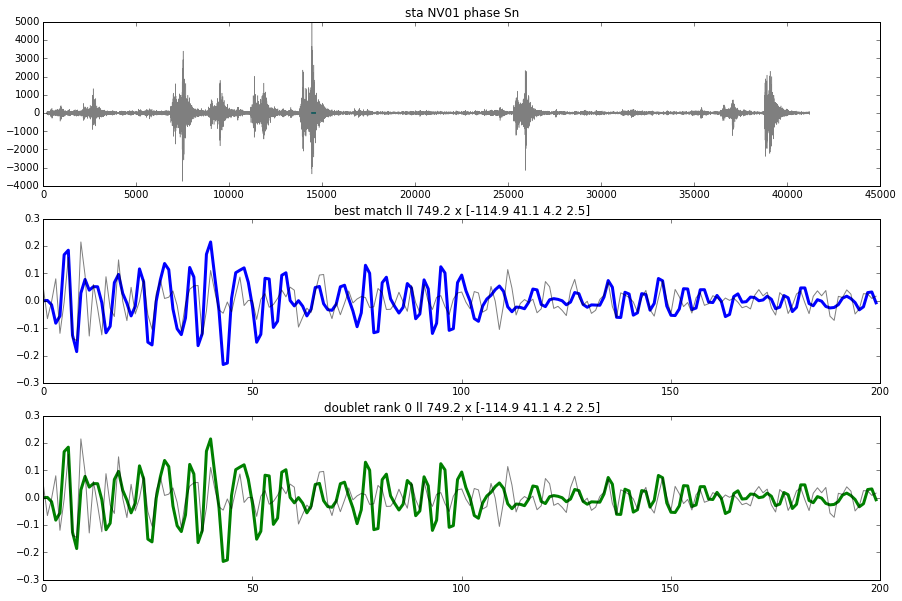

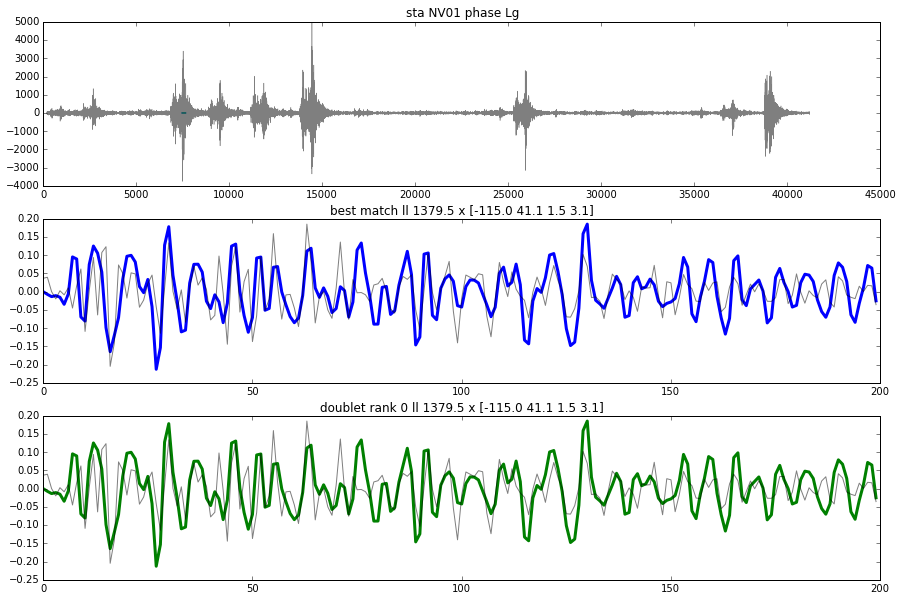

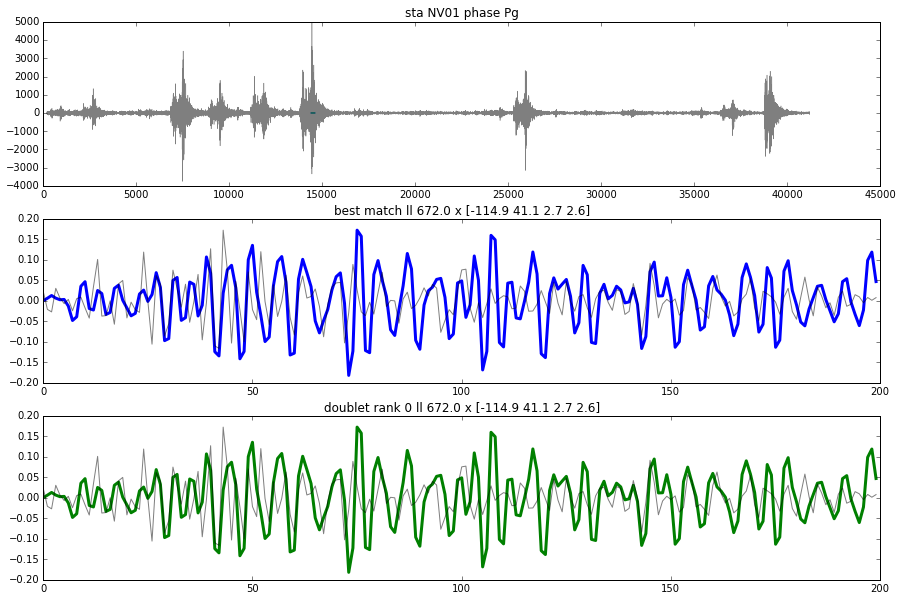

In [7]:
s = Sigvisa()

def fmt_x(x):
    return ("[%.1f %.1f %.1f %.1f]" % (x[0,0], x[0,1], x[0,2], x[0,4]))

global_srate = 1.0 # granularity at which to make atime proposals, NOT
                       # tied to the srate of any particular signal
global_stime = sg.inference_region.stime
global_etime = sg.inference_region.etime
N = int((sg.inference_region.etime - sg.inference_region.stime)*global_srate)


for sta in sorted(stas):
    
    sta = s.get_default_sta(sta)
    
    try:
        wn = sg.station_waves[sta][0]
    except:
        print "no waveform for", sta, "continuing"
        continue
        
    
        
    for phase in phases:

        wn_key = (wn.sta, wn.chan, wn.band, phase)
        
        training_xs, weights, posteriors = compute_proposal_distribution(sg, stas=(sta,), 
                                                                         phases=(phase,), 
                                                                         origin_stime=global_stime,
                                                                         origin_etime=global_etime,
                                                                         ar_advantage=False)
        
        if training_xs is None:
            continue
        
        weights = np.array(weights)
        if len(weights) == 0:
            print "no training arrivals for %s at %s, skipping" % (phase, sta)
            continue


        sorted_idxs = sorted(np.arange(len(weights)), key = lambda i : -weights[i])

        atime_lls = sg._cached_atime_posteriors
        
        best_match_idx = sorted_idxs[0]
        best_match_x = training_xs[best_match_idx]
        best_match_signal = proposals[best_match_idx][1][wn_key]
        best_match_lls = atime_lls[best_match_idx][1][(wn.label, phase)][0]
        best_align = np.argmax(best_match_lls)

        doublet_idx = None
        for doublet_rank, idx in enumerate(sorted_idxs):
            x = training_xs[idx]
            lon, lat, depth = x[0,0], x[0,1], x[0,2]
            if np.abs(lon - (-114.9)) > 0.5: continue
            if np.abs(lat - (41.15)) > 0.5: continue
            if np.abs(depth - 10) > 10: continue
            doublet_idx = idx
            break

        if doublet_idx is None:
            doublet_match_signal = np.zeros((200,))
            doublet_align = wn.npts/2
            doublet_title = "no doublets in training set generate phase %s at %s" % (phase, sta)
        else:
            doublet_x = training_xs[doublet_idx]
            doublet_match_signal = proposals[doublet_idx][1][wn_key]
            doublet_match_lls = atime_lls[doublet_idx][1][(wn.label, phase)][0]
            doublet_align = np.argmax(doublet_match_lls)
            doublet_title = "doublet rank %d ll %.1f x %s" % (doublet_rank, np.max(doublet_match_lls), fmt_x(doublet_x))

        plot_signal_with_alignments(wn.get_value().data, 
                                    "sta %s phase %s" % (sta, phase),
                                    best_match_signal, 
                                    best_align, 
                                    "best match ll %.1f x %s" % (np.max(best_match_lls), fmt_x(best_match_x)),
                                    doublet_match_signal,
                                    doublet_align,
                                    doublet_title)




In [9]:
print proposals[0][1].keys()

[('NV01', 'SHZ', 'freq_0.8_4.5', 'Lg'), ('NV01', 'SHZ', 'freq_0.8_4.5', 'Pg')]
